In [1]:
%%capture
from kls import bdh, bdh_bulk, get_kls_series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from bbg.sapi import BbgSapi
sapi = BbgSapi()
from collections import defaultdict
from datetime import datetime, timedelta 

import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
df = bdh_bulk({'fx': 'USDMXN Curncy', 'fx_policy': 'MPSW2B Index', 'usd_policy': 'USSW2 Index', 'credit_spread': 'MEX CDS USD SR 5Y D14 Corp', 'terms_trade': 'CTOTMXN Index', 'fx_cpi': 'MXCCYOY Index', 'usd_cpi': 'CPI XYOY Index', 'us_10s': 'USGG10YR Index', 'spx': 'SPX Index', 'vol': 'USDMXNV3M Curncy'}, '19900101', '20250101')

df.fillna(method='ffill', inplace=True)

df['yld_diff'] = (df['fx_policy'] - df['fx_cpi']) - (df['usd_policy'] - df['usd_cpi'])
#df['yld_diff'] = df['mxn_policy'] - df['usd_policy']

df = df.dropna()

In [3]:
df = df.loc[df.index > '2016-01-01']

spot = []
model = []
date = []

for i in range(200, len(df.index)):
    spot.append(df.fx.iloc[i])  
    X_train = df[['yld_diff', 'terms_trade', 'credit_spread', 'us_10s', 'spx', 'vol']].iloc[i - 125: i - 25]
    y_train = df[['fx']].iloc[i - 125: i - 25]
    X_test = df[['yld_diff', 'terms_trade', 'credit_spread', 'us_10s', 'spx', 'vol']].iloc[i - 24: i]
    y_test = df[['fx']].iloc[i - 24: i]
    model1 = LinearRegression().fit(X_train, y_train)
    y_test['y_pred'] = model1.predict(X_test)
    model.append(y_test.y_pred.iloc[-1])
    date.append(df.index[i])
    


In [4]:
len(spot) == len(model) == len(date)

True

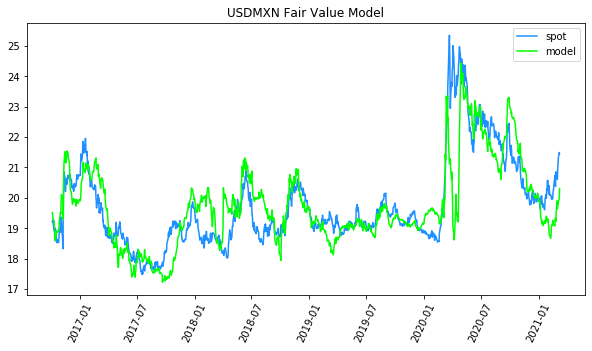

In [5]:
spot = pd.DataFrame(spot)
model = pd.DataFrame(model)
date = pd.DataFrame(date)

combo = pd.concat([date, spot, model], axis = 1)
combo.columns = ['date', 'spot', 'model']
combo.set_index('date', inplace = True)


fig, ax = plt.subplots(figsize = (10,5))

plt.plot(combo.spot, label = 'spot', color = 'dodgerblue');
plt.plot(combo.model, label = 'model', color = 'lime');

plt.legend();
plt.title('USDMXN Fair Value Model');
plt.xticks(rotation = 65);

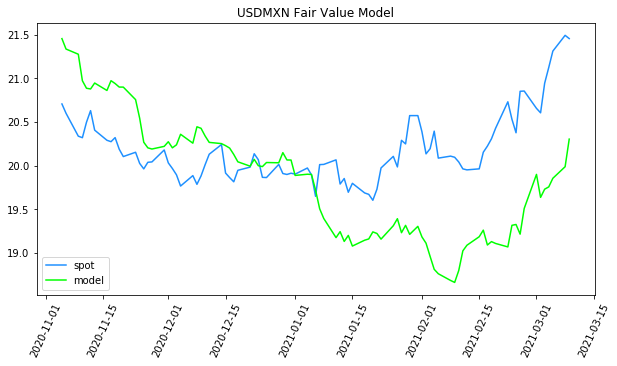

In [6]:
fig, ax = plt.subplots(figsize = (10,5))

plt.plot(combo.tail(90).spot, label = 'spot', color = 'dodgerblue');
plt.plot(combo.tail(90).model, label = 'model', color = 'lime');

plt.legend();
plt.title('USDMXN Fair Value Model');
plt.xticks(rotation = 65);

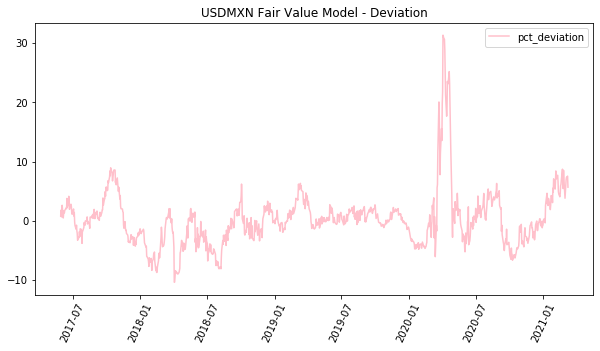

In [7]:
combo['pct_deviation'] = (((combo.spot / combo.model) -1)*100).round(2)

fig, ax = plt.subplots(figsize = (10,5))

plt.plot(combo.pct_deviation.tail(1000), label = 'pct_deviation', color = 'pink');

plt.legend();
plt.title('USDMXN Fair Value Model - Deviation');
plt.xticks(rotation = 65);

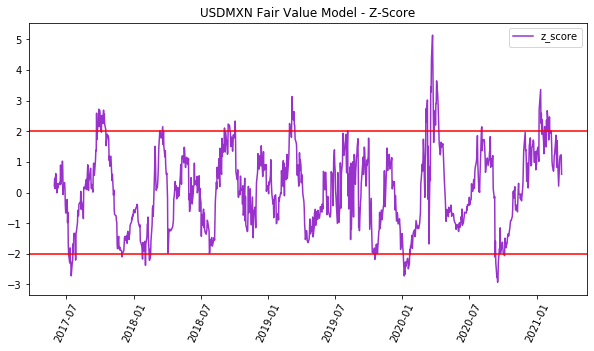

In [8]:
combo['z_score'] = (combo['pct_deviation'] - combo['pct_deviation'].rolling(60).mean()) / combo['pct_deviation'].rolling(60).std()

fig, ax = plt.subplots(figsize = (10,5))

plt.plot(combo.z_score.tail(1000), label = 'z_score', color = 'darkorchid');
plt.axhline(y=2, color='r')
plt.axhline(y=-2, color='r')


plt.legend();
plt.title('USDMXN Fair Value Model - Z-Score');
plt.xticks(rotation = 65);

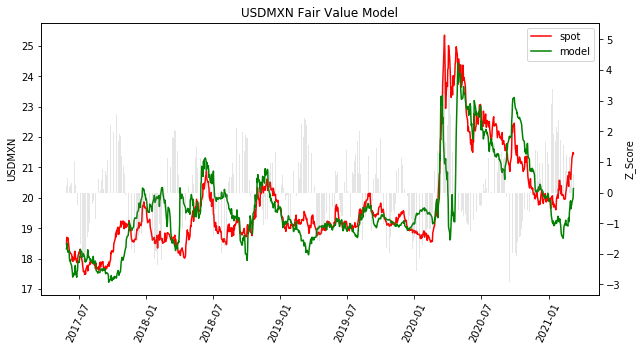

In [9]:
lookback = 1000

fig, ax1 = plt.subplots(figsize = (10,5))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.plot(combo.tail(lookback).spot, color = 'red', label = 'spot');
ax1.plot(combo.tail(lookback).model, color = 'green', label = 'model');

ax2.bar(combo.tail(lookback).index, combo.tail(lookback).z_score, color = 'gray', label = 'z_score', alpha = 0.2);
#ax2.axhline(y = -2, color = 'gray', alpha = 0.2)
#ax2.axhline(y = 2, color = 'gray', alpha = 0.2)

ax1.tick_params(axis = 'x', rotation = 65);

ax1.legend();
ax1.set_title('USDMXN Fair Value Model');
ax1.set_ylabel('USDMXN');
ax2.set_ylabel('Z_Score');

In [10]:
r2_score(spot, model)

0.596233501683531

In [11]:
combo.tail(1)

,spot,model,pct_deviation,z_score
date,,,,
2021-03-09,21.4561,20.304715,5.67,0.596647


In [12]:
model1.coef_

array([[-2.26042618e-01, -3.44031550e-02,  1.83767054e-02,
        -1.13265007e+00,  2.85773733e-05,  1.47882195e-01]])

In [13]:
combo.count()

spot             1170
model            1170
pct_deviation    1170
z_score          1111
dtype: int64

In [14]:
combo['1m_fwd'] = (((combo.spot.shift(-10) / combo.spot)-1)*100).round(2)

too_low = combo[(combo.z_score < -2)][['z_score', '1m_fwd']]
print('mean: '+str(too_low['1m_fwd'].mean().round(2)))
print('median: '+str(too_low['1m_fwd'].median().round(2)))
print('max: '+str(too_low['1m_fwd'].max().round(2)))
print('min: '+str(too_low['1m_fwd'].min().round(2)))

mean: 0.67
median: 0.3
max: 6.29
min: -4.5


In [15]:
combo = combo.head(800)

combo['1m_fwd'] = (((combo.spot.shift(-30) / combo.spot)-1)*100).round(2)

too_high = combo[(combo.z_score > 2)][['z_score', '1m_fwd']]
print('mean: '+str(too_high['1m_fwd'].mean().round(2)))
print('median: '+str(too_high['1m_fwd'].median().round(2)))
print('max: '+str(too_high['1m_fwd'].max().round(2)))
print('min: '+str(too_high['1m_fwd'].min().round(2)))

mean: 0.35
median: -0.5
max: 7.17
min: -6.51
